In [1]:
from pathlib import Path
import time
import torch
import numpy as np
import pandas as pd
from dataset import LinearDynamicalDataset, WHDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
#import plotly.graph_objects as go
from transformer_sim import Config, TSTransformer
import tqdm
import argparse
import metrics

In [2]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [3]:
torch.manual_seed(420)
np.random.seed(430)

In [4]:
# Overall settings
out_dir = "../out"

# System settings
nu = 1
ny = 1
#seq_len = 600
batch_size = 32 # 256
fixed_system = False # Are we testing on a fixed system?
model_seed = None

# Compute settings
cuda_device = "cuda:0"
no_cuda = True
threads = 32
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")

In [5]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir / "ckpt_sim_wh.pt", map_location=device)
cfg = exp_data["cfg"]
# For compatibility with initial experiment without seed
try:
    cfg.seed
except AttributeError:
    cfg.seed = None

In [6]:
seq_len = cfg.seq_len_ctx + cfg.seq_len_new
nx = cfg.nx
model_seed = cfg.seed if model_seed is None else model_seed 

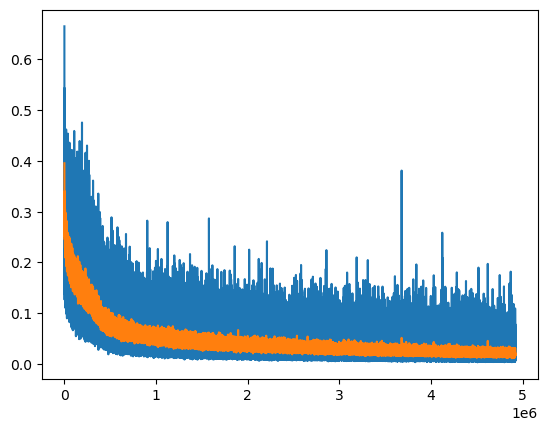

In [7]:
loss_smooth = pd.Series(exp_data["LOSS"]).rolling(100).mean()
plt.figure()
plt.plot(exp_data["LOSS"], label="TRAINING_LOSS")
plt.plot(loss_smooth, label="TRAINING_LOSS_SMOOTH");

In [8]:
model_args = exp_data["model_args"]
conf = Config(**model_args)
model = TSTransformer(conf).to(device)
model.load_state_dict(exp_data["model"]);

In [9]:
# Create data loader
test_ds = WHDataset(nx=nx, nu=nu, ny=ny, seq_len=seq_len,
                    system_seed=cfg.seed if fixed_system else None,
                    data_seed=0, fixed_system=fixed_system)
#test_ds = LinearDynamicalDataset(nx=cfg.nx, nu=cfg.nu, ny=cfg.ny, seq_len=cfg.seq_len_ctx+cfg.seq_len_new)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=threads)

In [10]:
batch_y, batch_u = next(iter(test_dl))
batch_y = batch_y.to(device)
batch_u = batch_u.to(device)
with torch.no_grad():
    batch_y_ctx = batch_y[:, :cfg.seq_len_ctx, :]
    batch_u_ctx = batch_u[:, :cfg.seq_len_ctx, :]
    batch_y_new = batch_y[:, cfg.seq_len_ctx:, :]
    batch_u_new = batch_u[:, cfg.seq_len_ctx:, :]
    batch_y_sim = model(batch_y_ctx, batch_u_ctx, batch_u_new)

In [11]:
batch_y_sim = batch_y_sim.to("cpu").detach().numpy()
batch_y_new = batch_y_new.to("cpu").detach().numpy()
batch_u_new = batch_u_new.to("cpu").detach().numpy()
batch_sim_err = batch_y_new[:, :, :] - batch_y_sim[:, :, :]

In [12]:
t = np.arange(1, batch_u_new.shape[1]+1) + cfg.seq_len_ctx

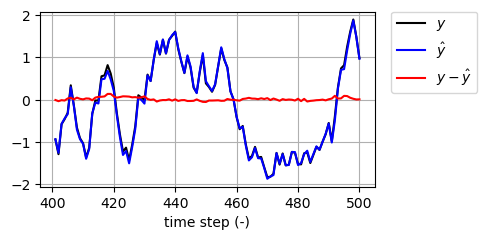

In [13]:
plt.figure(figsize=(5, 2.5))
idx = 10
plt.plot(t, batch_y_new[idx, :, :], 'k', label="$y$")
plt.plot(t, batch_y_sim[idx, :, :], 'b', label="$\hat y$")
plt.plot(t, batch_sim_err[idx, :, :], 'r', label="$y - \hat y$")
plt.grid(True)
plt.xlabel("time step (-)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig(fig_path / "wh_sim_single.pdf")

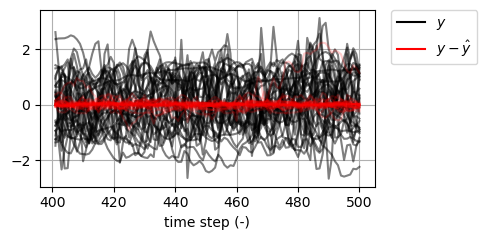

In [14]:
plt.figure(figsize=(5, 2.5))
#plt.ylim([-3, 3])
plt.plot(t, batch_y_new.squeeze(-1).T, "k", alpha=0.5);
plt.plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
plt.plot(t, batch_sim_err.squeeze(-1).T, "r", alpha=0.2);
plt.plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y - \hat y$");
plt.grid(True)
plt.xlabel("time step (-)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig(fig_path / "wh_sim_batch.pdf")

In [15]:
skip = 0
rmse = metrics.rmse(batch_y_new, batch_y_sim, time_axis=1)

In [16]:
print(f'iterations: {exp_data["cfg"].max_iters}')
print(f'train_time: {exp_data["train_time"]/3600/24} days')
print(f'rmse: {rmse.mean()}')

iterations: 5000000
train_time: 4.48948106120582 days
rmse: 0.11938512325286865
